# Time Series Analysis

## Review

### What is time series analysis?

A time series is a series of data points indexed (or listed or graphed) in time order. `Time series analysis` comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. 

Usually, time series contains 3 componets: trend, periodic/seasonal, noise/residual.
$$y(t) = trend(t) + periodic(t) + noise(t)$$
or
$$y(t) = trend(t) \times periodic(t) \times noise(t)$$

|![example of time series decomposition](https://user-images.githubusercontent.com/21985915/43876851-62508334-9bc9-11e8-900e-8ba830c2678a.png)|
|:-:|
|*Example of time series decomposition*|



In [ ]:
!pip install fbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Information from noise

#### 1. Autocorrelation

Autocorrelation function is defined as:
$$C(s) = \frac{E[(x_{t+s} - \mu)(x_t - \mu)]}{\sigma^2}$$

In [ ]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from fbm import fgn, fbm
import numpy as np

In [ ]:
def visual_noise(x):
    plt.figure(figsize=(18, 5))
    plt.subplot(131)
    plt.title("noise")
    plt.plot(x)
    plt.subplot(132)
    plt.title("profile")
    plt.plot(np.cumsum(x))
    plt.subplot(133)
    plot_acf(x, ax=plt.gca())
    plt.ylim(-0.25, 0.25)
    plt.show()

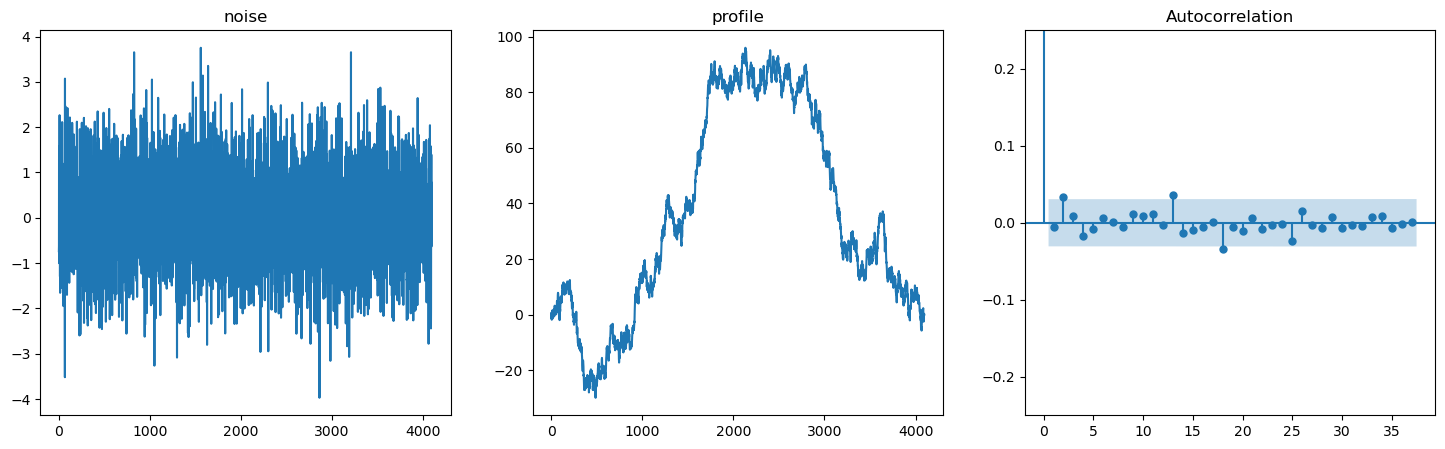

In [ ]:
# white noise 
# profile is the cumulative sum of the noise
# rxx(0) = 1, othercases = 0
# Hurst = 0.5
x = np.random.randn(4096)
x = x - np.mean(x)
visual_noise(x)

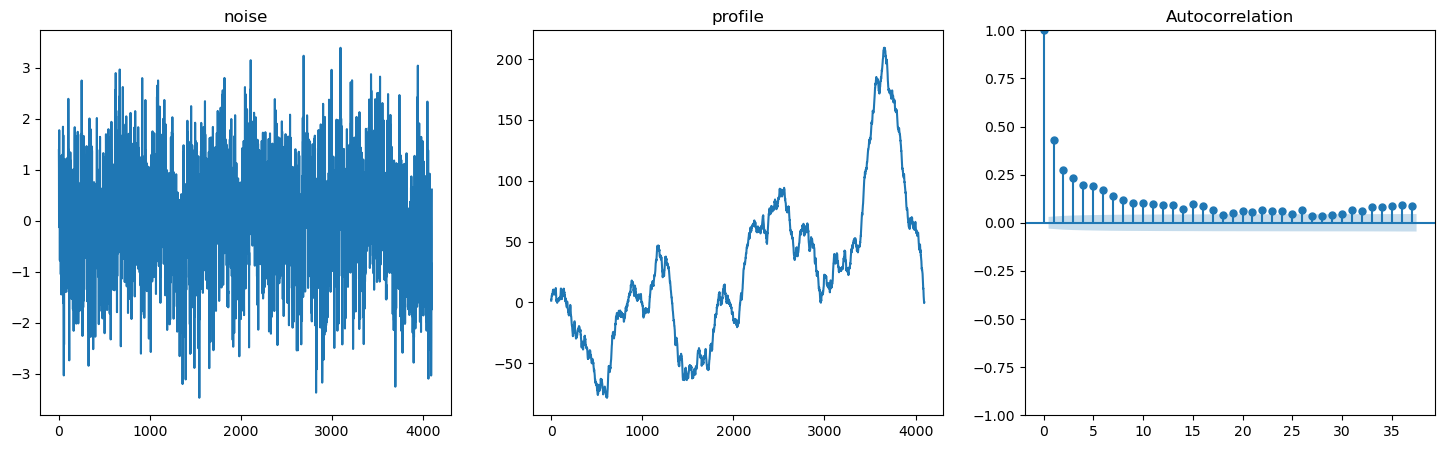

In [ ]:
# positive autocorrelation
x = fgn(4096, hurst=0.75)
x = x - np.mean(x)
x = x / x.std()
visual_noise(x)

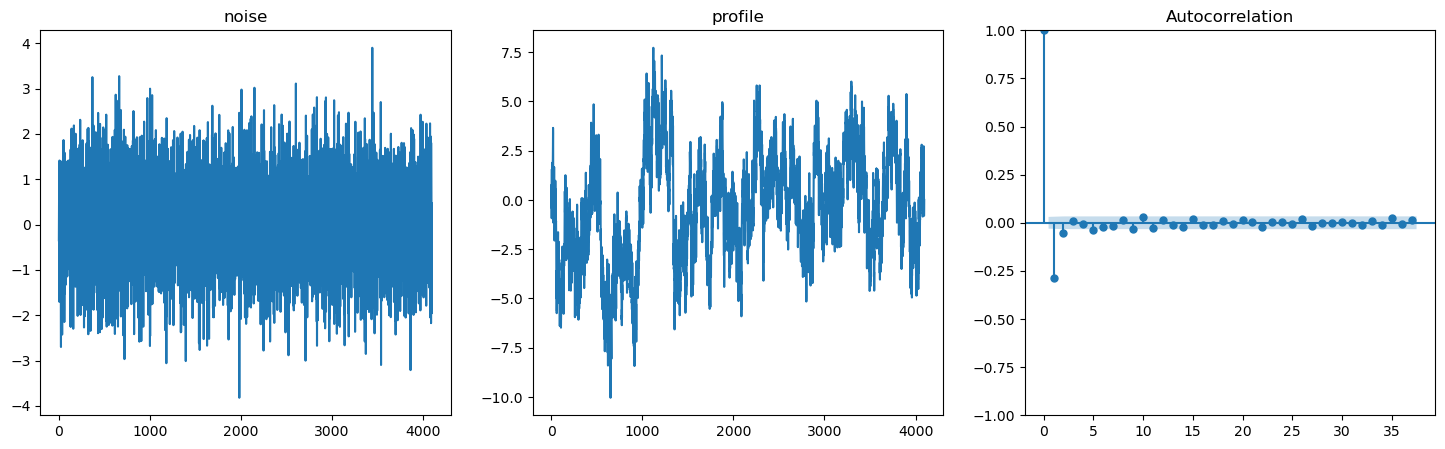

In [ ]:
# negative autocorrelation
x = fgn(4096, hurst=0.25)
x = x - np.mean(x)
x = x / x.std()
visual_noise(x)

#### 2. correlation time

The correlation time is defined as: $\tau = \int_0^{\infty} s C(s)\mathrm{d}s$. 

If the integral is convergent, the time series is a short-term correlated series. Otherwise, the time series is a long-term correlated series.

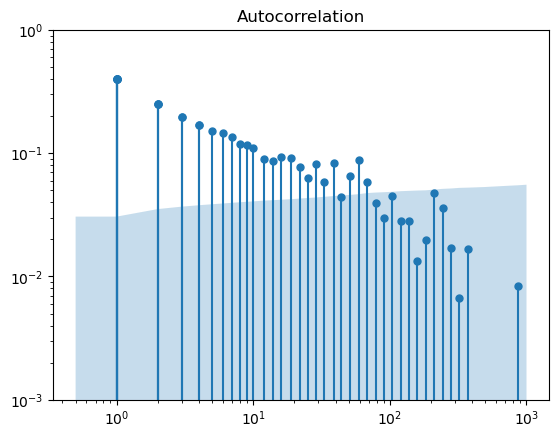

In [ ]:
# example of long term correlation
# C(s) ~ s^(- gamma )
# very noisy tail (large s)
x = fgn(4096, hurst=0.75)
plot_acf(x, lags=np.logspace(0, 3, 50))
plt.ylim(0.001, 1)
plt.xscale('log')
plt.yscale('log')
plt.show()

#### 3. Self-affinity

`Self-affinity` is a feature of a fractal whose pieces are scaled by different amounts in the x- and y-directions. In the case of time series, the x axis will be time, and y axis will be your measurement.

Assume we have a time series y(t), the increment x(t, dt) is y(t + dt) - y(t). If the time series is a self-affine time series, the increment should keep the same distribution under different scales, which means:

$$|a|^H x(t, dt) \sim x(t, a dt)$$

$\sim$ means right-hand side and left-hand side have the same distribution

##### Hurst exponent for white noise.
If $x_0, x_1, x_2, \cdots, x_N$ are i.i.d (independent and identically distributed) and ***zero-mean*** random variables, because of the central limited theorem, for large scale, the increment will be a Gaussian distribution. 

$$Var[\sum_{i=0}^n x_i] = \sum_{i=0}^n Var[x_i]$$

So
$$\sigma[\sum_i x_i] = \sqrt{\sum_{i=0}^n Var[x_i] } = \sqrt{n \sigma^2} = \sqrt{n}\sigma $$

We can get H for white noise is 0.5

In [ ]:
# Create random noise or fractional gaussian noise as x(t)
H = 0.7
t = np.arange(256000)
# x_t = np.random.randn(256000) # totally random
x_t = fgn(256000, hurst=H)
x_t = x_t - np.mean(x_t) # remove the mean value
x_t = x_t / x_t.std()

y_t = np.cumsum(x_t) # calculate the profile, y(t)
delta_t = []
sigma = []

For testing self-affinity, we can measure the profile under different scales. If under any given scale, the distribution of the increments keeps the same, and the width, or standard deviation increase power-lawly with the increase of scale, The time series is self-affine.

The power law exponent is `Hurst exponent`

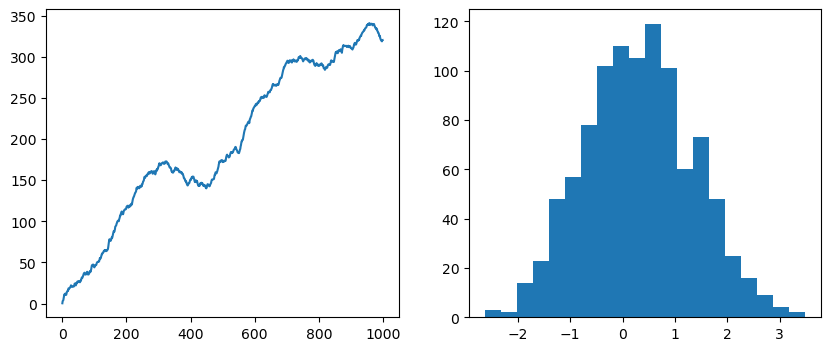

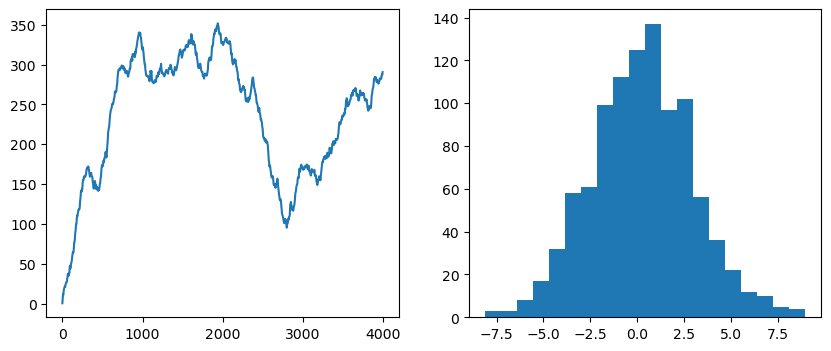

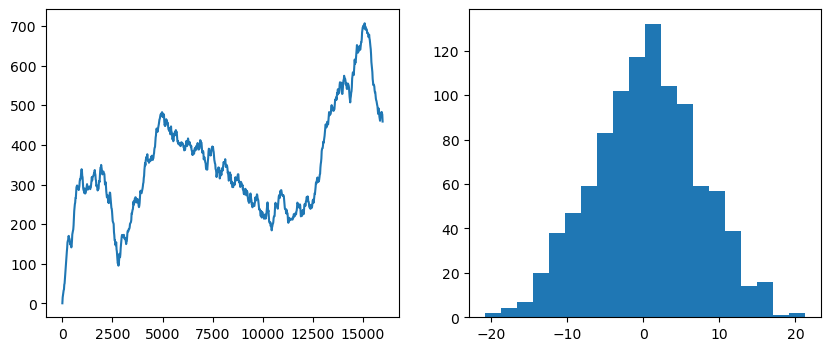

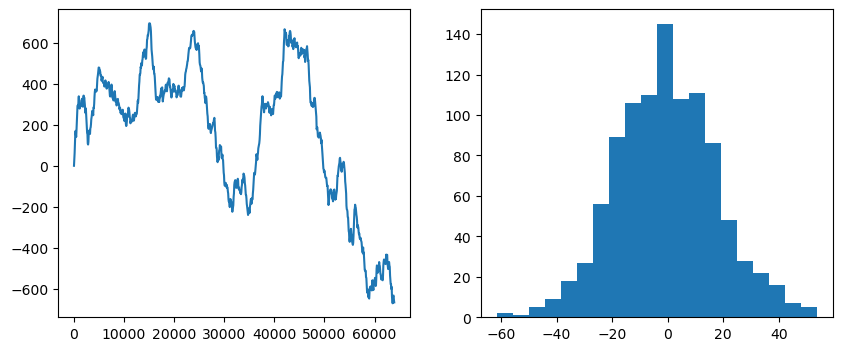

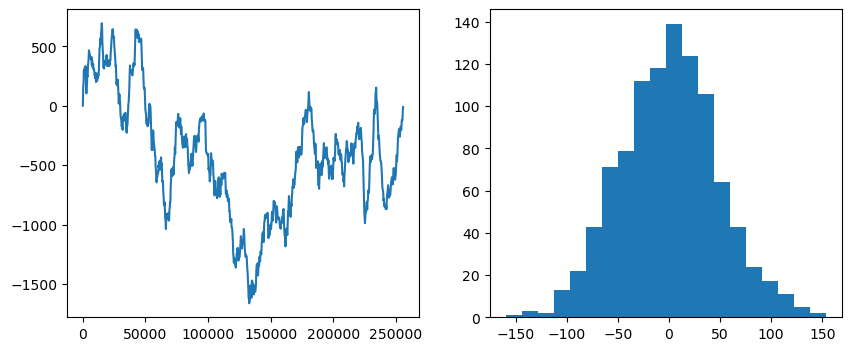

In [ ]:
for step in [1, 4, 16, 64, 256]:
    sub_t = t[:1000 * step: step]
    sub_y = y_t[:1000 * step: step]

    dy = np.diff(sub_y)
    delta_t.append(step)
    sigma.append(dy.std())

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(sub_t, sub_y)
    plt.subplot(1, 2, 2)
    plt.hist(dy, bins=20)
    plt.show()

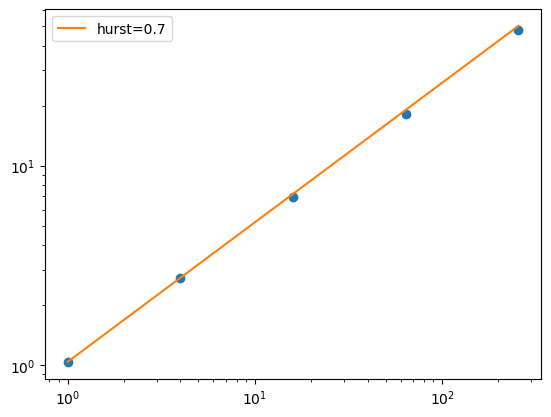

In [ ]:
plt.plot(delta_t, sigma, 'o')
plt.plot(delta_t, np.array(delta_t) ** H  * sigma[0]/ delta_t[0] ** H, label=f'hurst={H}')
plt.legend()
plt.xscale('log')
plt.yscale('log')

#### Fluctuation Analysis
The steps we did above, is Fluctuation analysis:
1. remove the mean value in $x(t_i)$ and compute profile $y(t_j) = \sum_{i=0}^j x(t_i)$
2. Divide profile in segments of length (scale) s
3. Calculate the increments for each window, and calculate the standard deviation of the increments, dominated by F(s)
4. For a self-affine time series, $F(s) \sim s^{-H}$

H = 0.5 means the increment is just white noise (random).

1 > H > 0.5 means the random walker can reach a farther point than the random case, this can only be true if the increment has a positive autocorrelation.

H < 0.5 then means the increment has a negative autocorrelation.

As we have seen in percolation when the autocorrelation is long-range, F(s) will be a straight line in the log-log plot. But when the autocorrelation is short-range, when the time scale is smaller than the correlation time, H will be different with 0.5. After the time scale becomes larger than the correlation time, H will be 0.5 (seems like random).

#### Detrended Fluctuation Analysis
But what if there is trend ? 

In [ ]:
# Create random noise or fractional gaussian noise as x(t)
H = 0.5
t = np.arange(256000)
# x_t = np.random.randn(256000) # totally random
x_t = fgn(256000, hurst=H)
x_t = x_t + t * 1e-5
x_t = x_t - np.mean(x_t) # remove the mean value

y_t = np.cumsum(x_t) # calculate the profile, y(t)
delta_t = []
sigma = []

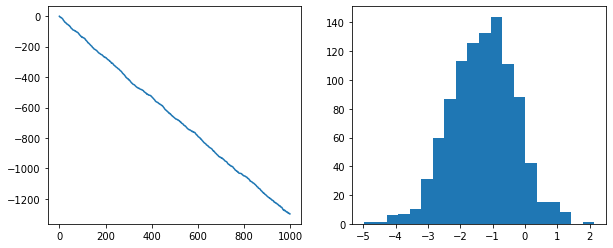

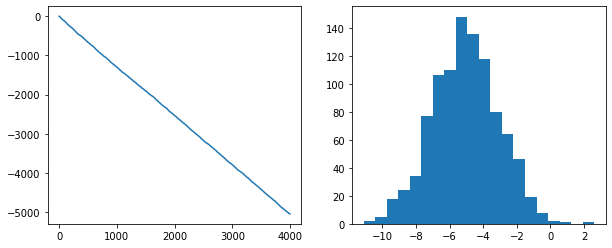

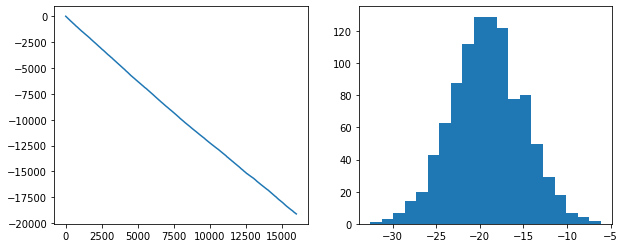

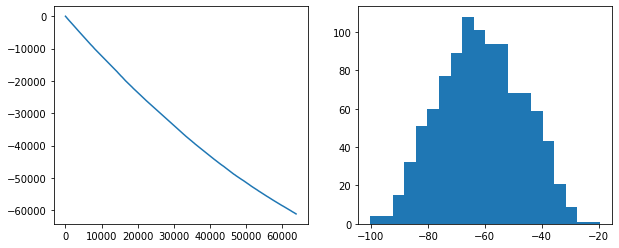

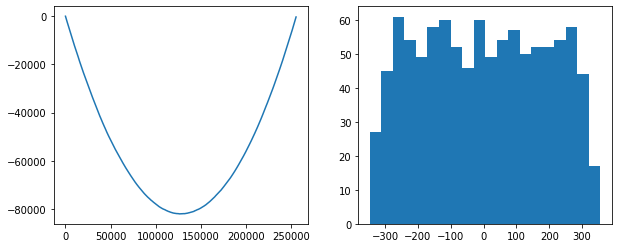

In [ ]:
for step in [1, 4, 16, 64, 256]:
    sub_t = t[:1000 * step: step]
    sub_y = y_t[:1000 * step: step]

    dy = np.diff(sub_y)
    delta_t.append(step)
    sigma.append(dy.std())

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(sub_t, sub_y)
    plt.subplot(1, 2, 2)
    plt.hist(dy, bins=20)
    plt.show()

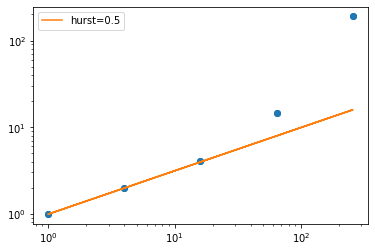

In [ ]:
plt.plot(delta_t, sigma, 'o')
plt.plot(delta_t, np.array(delta_t) ** H  * sigma[0]/ delta_t[0] ** H, label=f'hurst={H}')

plt.legend()
plt.xscale('log')
plt.yscale('log')

Because of the trend, the slope is significantly different from the real hurst exponent, for fixing this, one can remove the trend from the profile. Usually, remove the polynoimal trend.

1. remove the mean value in $x(t_i)$ and compute profile $y(t_j) = \sum_{i=0}^j x(t_i)$
2. Divide profile in segments of length (scale) s
3. remove the trends from each segment.
4. Calculate the increments for each window, and calculate the standard deviation of the increments, dominated by F(s)
5. For a self-affine time series, $F(s) \sim s^{-H}$


|![example of DFA](https://github.com/AlexMa123/BIU-Computational-Physics-2022/blob/main/img/TimeSeries/Illustration-of-Detrended-Fluctuation-Analysis-DFA-and-example-behavioral-time-series.ppm.png?raw=true)|
|:-:|
|*Example of DFA*|




### Fourier Transform
Discrete Fourier Transform (DFT) is defined as:
$$X_k = \sum_{n=0}^{N-1} x_n e^{- i \frac{2 \pi}{N} k n}$$

and $k = 0, 1, 2, \cdots N-1$. Fast Fourier Transform (FFT) is an fast algorithm that computes the DFT of a sequence.
#### Power Spectrum
The power spectrum is defined as: $S_k = \left| X_k \right|^2$. So $S_k = S_{N-k}$

$$f = k \frac{\text{sampling frequency}}{N}$$

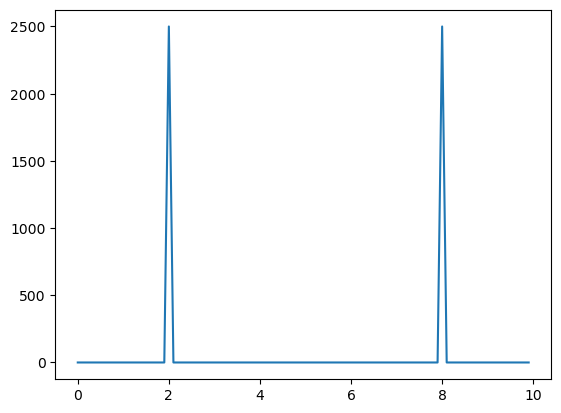

In [ ]:
t = np.arange(0, 10, 0.1)
y = np.sin(2 * t * np.pi * 2)
fft_result = np.fft.fft(y)
power_spectrum = np.abs(fft_result) ** 2
freqs = np.arange(0, 10, 10 / y.size)
plt.figure()
plt.plot(freqs, power_spectrum)
# plt.xlim(0)

inverse Fourier Transform

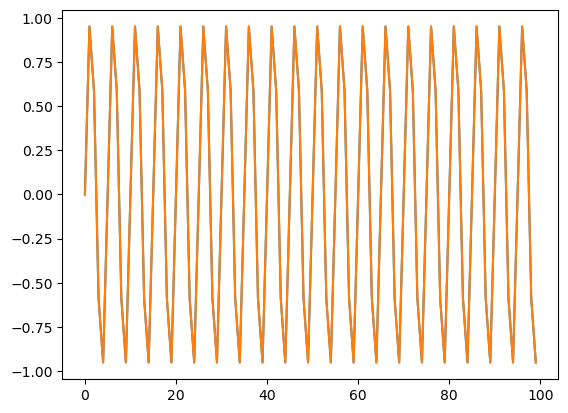

In [ ]:
plt.plot(y)
plt.plot(np.fft.ifft(fft_result).real)

Also, the maximum frequency can be detected by DFA is half of the samplilng frequency

(-1.0, 1.0)

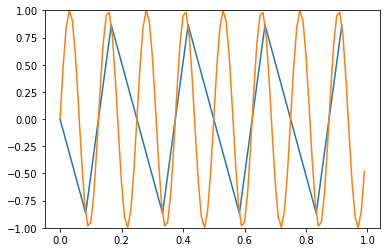

In [ ]:
t = np.arange(0, 1, 1 / 12)
# lower the sampling frequency to see what will happen, 1 / 16, 1 / 12
y = np.sin(8 * t * np.pi * 2)

t_signal = np.arange(0, 1, 0.01)
y_signal = np.sin(8 * t_signal * np.pi * 2)
plt.plot(t, y)
plt.plot(t_signal, y_signal, label='original_signal')
plt.ylim(-1, 1)

#### Fourier Transform for self-affine time series
Remember what we did for check self-affinity： rescale the increment's time interval, and the process looks the same. The larger the time interval, in other words, smaller the sampling frequency, it's nothing but zoom into the low-frequency part of the power spectrum, and the power spectrum should keep the same.

$P(f)$ should looks the same with $P(a f)$. The only function meet this condition is power-law

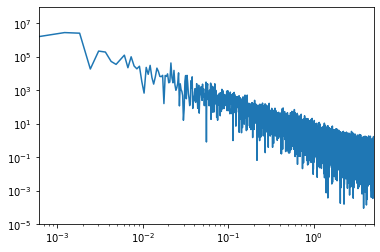

In [ ]:
y = fbm(4096 * 4, hurst=0.5)
y = y - np.mean(y)
fft_result = np.fft.fft(y)
power_spectrum = np.abs(fft_result) ** 2
freqs = np.arange(0, 10, 10 / y.size)
plt.figure()
plt.plot(freqs, power_spectrum)
plt.xlim(freqs[1], 5)
plt.ylim(1e-5, 1e8)
plt.xscale('log')
plt.yscale('log')

#### Bandpass filter
A bandpass filter is a filter that passes a certain bznd of frequency without attenuation. The particular band of frequency passes by the filter is known as passband.

With the help of the fourier transform, we can design an easy bandpass filter: set all the component out of the band as zero, then apply an inverse transform.

Here is an example:

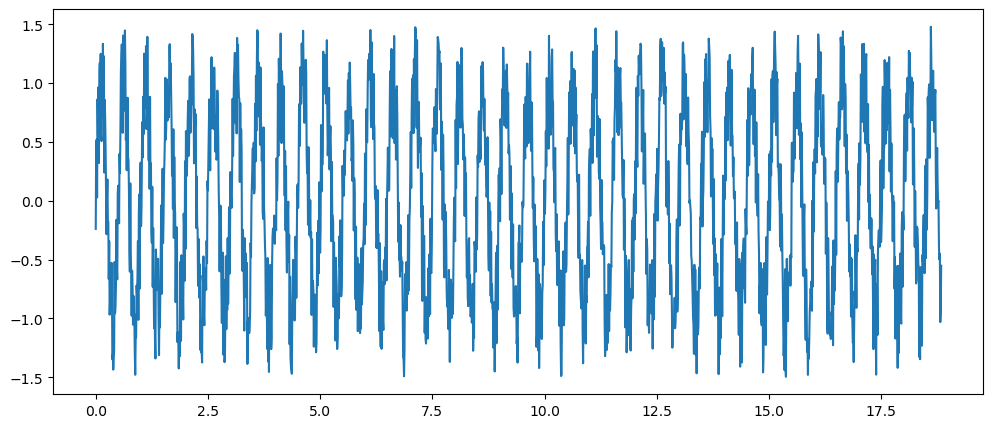

In [ ]:
t = np.arange(0, np.pi * 6, 0.01)
y = np.sin(2 * t * np.pi * 2) + np.random.rand(t.size) - 0.5 # Add noise to a sin function

plt.figure(figsize=(12, 5))
plt.plot(t, y)

(0.0, 5.0)

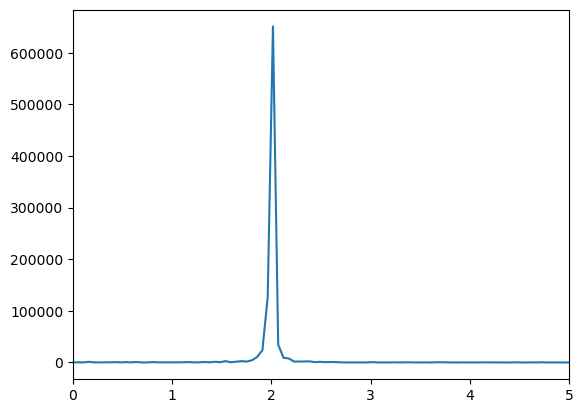

In [ ]:
fft_result = np.fft.fft(y)
power_spectrum = np.abs(fft_result) ** 2
freqs = np.arange(0, 100, 100 / y.size)

plt.plot(freqs, power_spectrum)
plt.xlim(0, 5)

To filter out the noise, we can set the fourier components out of the (1.6 Hz, 2.4 Hz) as zero then apply an inverse transform.

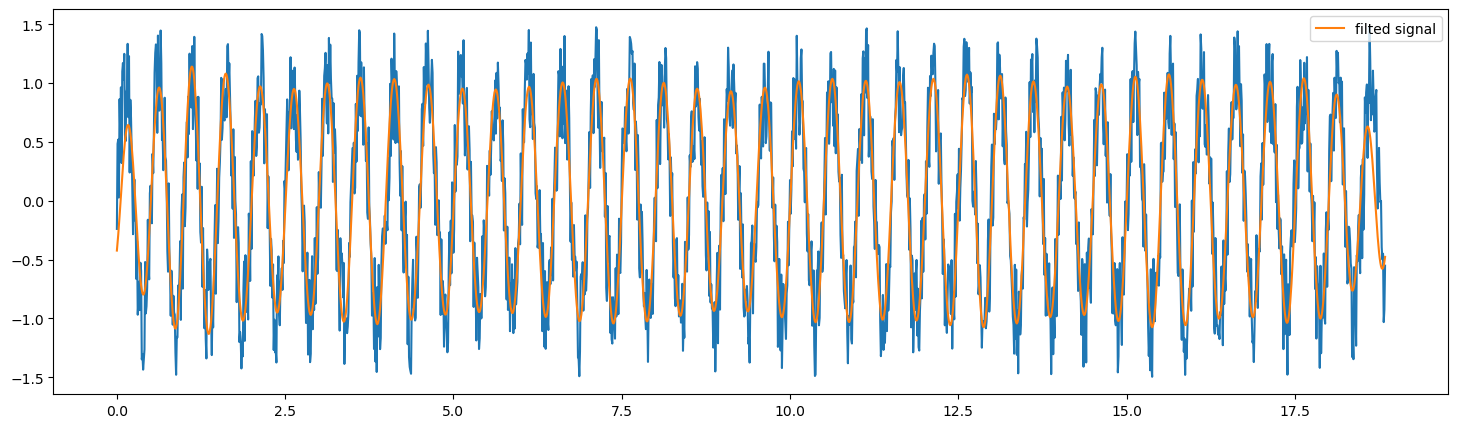

In [ ]:
index = np.where((1.6 < freqs) & (freqs < 2.4))[0]
filted_f = np.zeros_like(fft_result)
filted_f[index] = fft_result[index]
filted_f[fft_result.size - index] = fft_result[fft_result.size - index]
filted_signal = np.fft.ifft(filted_f).real
plt.figure(figsize=(18, 5))
plt.plot(t, y)
plt.plot(t, filted_signal, label='filted signal')
plt.legend()

#### Unevenly sampled data
Unevenly sampled data are quite common, examples include drill core data, astronomical observations, or stock price notations. But DFT can only estimate power spectrum from a evenly sampled data. For solving thie issue, we can use 1. interpolate or 2. Lomb-Scargle periodogram.

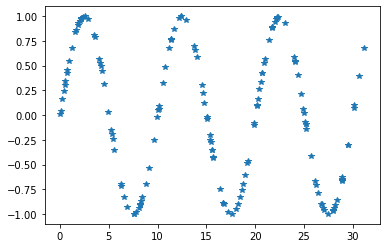

In [ ]:
x = np.random.uniform(0, 10*np.pi, 150)
x = np.sort(x)
y = np.sin(x * 2 * np.pi / 10)
plt.plot(x, y, '*')

##### Interpolate

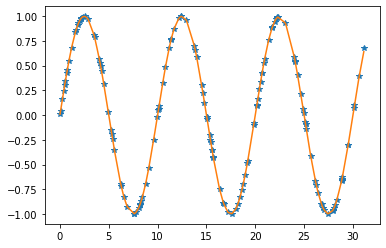

In [ ]:
# interpolate
x_resample = np.arange(x[0], x[-1], 0.1)
from scipy.interpolate import interp1d
f = interp1d(x, y, kind='linear', assume_sorted=True)
y_resample = f(x_resample)
plt.plot(x, y, '*')
plt.plot(x_resample, y_resample)

(0.0, 1.0)

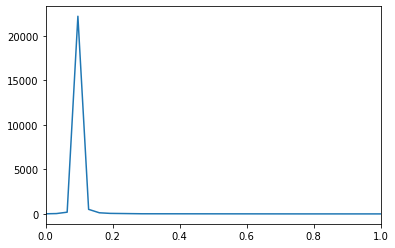

In [ ]:
fft_result = np.fft.fft(y_resample)
power_spectrum = np.abs(fft_result) ** 2
freqs = np.arange(0, 10, 10 / y_resample.size)
plt.figure()
plt.plot(freqs, power_spectrum)
plt.xlim(0, 1)

## Exercise

## Ex1

Here is a rr interval time series. Please implement the DFA algorithm (use a linear trend) to analyze the data.

Make a dfa plot and fit the hurst exponent.

In [ ]:
!wget https://raw.githubusercontent.com/AlexMa123/BIU-ComplexSystem/main/rr-intervals -O rr-intervals

--2023-01-17 10:35:49--  https://raw.githubusercontent.com/AlexMa123/BIU-ComplexSystem/main/rr-intervals
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 355085 (347K) [text/plain]
Saving to: 'rr-intervals'

     0K .......... .......... .......... .......... .......... 14%  223K 1s
    50K .......... .......... .......... .......... .......... 28% 1.39M 1s
   100K .......... .......... .......... .......... .......... 43% 3.74M 0s
   150K .......... .......... .......... .......... .......... 57%  695K 0s
   200K .......... .......... .......... .......... .......... 72%  375K 0s
   250K .......... .......... .......... .......... .......... 86%  424K 0s
   300K .......... .......... .......... .......... ......    100%  230K=0.8s

2023-01-17 10:35:51 (434 K

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = np.loadtxt('rr-intervals')
data = data / 100
scales = np.logspace(0.5, 4, 20).astype(int) # the scales used by DFA

Text(0, 0.5, 'rri/s')

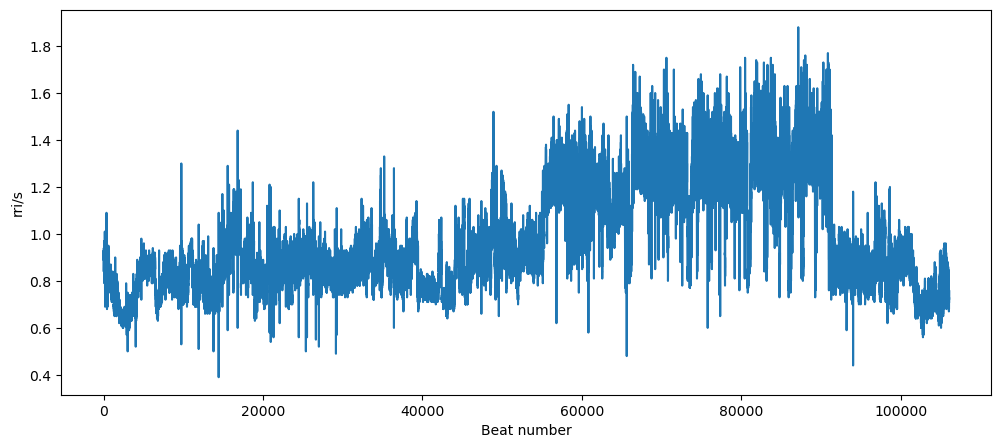

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(data)
plt.xlabel('Beat number')
plt.ylabel('rri/s')
# plt.xlim(0, 200)

In [ ]:
### Write your anwser below

## Ex2. 
Here is a real 5-min ECG signal with a 200 Hz sample frequency

In [ ]:
!wget https://raw.githubusercontent.com/AlexMa123/BIU-ComplexSystem/main/ecg.txt -O ecg.txt

--2023-01-17 00:03:42--  https://raw.githubusercontent.com/AlexMa123/BIU-ComplexSystem/main/ecg.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608276 (1.5M) [text/plain]
Saving to: 'ecg.txt'

     0K .......... .......... .......... .......... ..........  3%  399K 4s
    50K .......... .......... .......... .......... ..........  6%  926K 3s
   100K .......... .......... .......... .......... ..........  9% 13.0M 2s
   150K .......... .......... .......... .......... .......... 12% 3.60M 1s
   200K .......... .......... .......... .......... .......... 15% 1.41M 1s
   250K .......... .......... .......... .......... .......... 19% 17.9M 1s
   300K .......... .......... .......... .......... .......... 22% 32.4M 1s
   350K .......... .......... ........

(0.0, 20.0)

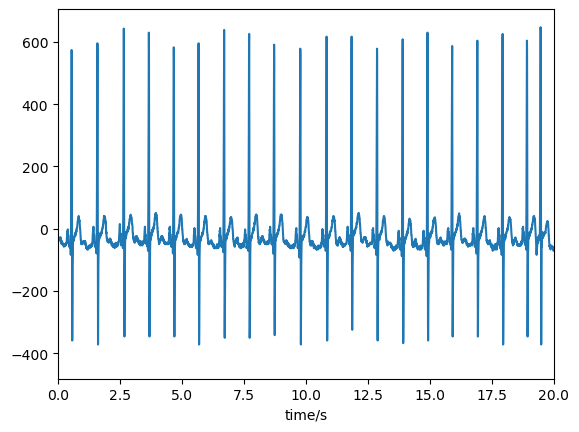

In [ ]:
ecg_data = np.loadtxt('ecg.txt')
t = np.arange(0, ecg_data.size / 200, 1 / 200)
plt.plot(t, ecg_data)
plt.xlabel('time/s')
plt.xlim(0, 20)

Use the `find_peaks` function from `scipy.signal` to detect peaks in ECG. Find more information about this function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

1. let the position of the peaks (in seconds) as the x axis, and the interval between the peak and its next peak as y axis, ***visualize how the interval (1 / heart rate) changes with time.***
2. Resample y to 4 Hz then calculate and visualize its power spectrum.
3. calculate the power in the band: (0.12-0.4 Hz) $\sum_{f=0.12}^{0.4} P(f) df$
4. Apply a bandpass filter that only keeps the oscillation in the band (0.12-0.4 Hz)

In [ ]:
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

 ## Ex 3. 
 Get the peak height of the ECG you analyzed in the last question and resample it to 4 Hz. Calculate the Pearson coefficient between the peak height and the filtered signal obtained from the last question.

To calculate the coefficient,  you can use the `pearsonr` function from `scipy.stats`.

In [ ]:
from scipy.stats import pearsonr